In [7]:
import pandas as pd
import random
import numpy as np
import spacy
from tqdm import tqdm
from pprint import pprint
import re
import os
import time
import pickle
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import nltk.data
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import line_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.chunk import tree2conlltags
from sklearn.model_selection import train_test_split
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import PorterStemmer
from nltk.stem.porter import *
from gensim import corpora, models
from wordcloud import WordCloud, STOPWORDS
import nltk, math, codecs
from gensim.models import Doc2Vec
from nltk.cluster.kmeans import KMeansClusterer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
pd.set_option('display.max_colwidth', 200)
from nltk.collocations import *
import warnings
warnings.filterwarnings("ignore")

unable to import 'smart_open.gcs', disabling that module


In [ ]:
nltk.download('all')

In [9]:
n=1000000
s=950000
random.seed(3358439386)
skip = sorted(random.sample(range(n),n-s))
data = pd.read_csv("/Users/sbalas203/Downloads/Chomsky-NLP/ivr_utterances_march.csv", skiprows=skip, header=0)

In [10]:
data.head(5)

,REPORTED_UTTERANCE_TEXT,IVR_END_STATUS_NM,CUSTOMER_ACCOUNT_ID,IVR_CUSTOMER_MARKET_NM,CALL_DATE,REPORTED_NAVIGATION_MODULE_NM,REPORTED_NAVIGATION_MODULE_FUNCTION_NM,LAST_NON_TRANSFER_MODULE_NM,LAST_NON_TRANSFER_MODULE_FUNCTION_NM
0,pay my bill,self_service,480402628,Florida,2020-03-03,PAYMENT,PaymentConfSMS,PAYMENT,PayConfirmation
1,would like my contract,agent,29830704,Portland,2020-03-18,GLOBAL,BroadcastMsg,CALLERINTENT,NLDisambig_Reprompt
2,need to talk to agent,agent,550243294,Keystone,2020-02-29,APPOINTMENT,FutureAppointment,CALLERINTENT,NLDisambig_Reprompt
3,representative,agent,550807015,Nashville,2020-03-20,APPOINTMENT,AppointmentsPI,CALLERINTENT,NLDisambig_Reprompt
4,charges,agent,519773765,Beltway,2020-03-06,BILLING,BillingMenus,BILLING,BillingAgent


In [11]:
data.REPORTED_NAVIGATION_MODULE_FUNCTION_NM.value_counts().head(20)

Survey Offer         140807
BroadcastMsg         119547
PayConfirmation       64277
RefreshFollowUp       61787
SMSOrCall             51547
PaymentConfSMS        45359
ModemResetVerify      36811
BillingAlignment      32002
Transfer              30519
BillingVideoX1SMS     28197
UpdatedBalance        26182
ModemResetOffer       25368
Agent                 21922
BillingMenus          20327
System Restart        13355
SMS Chat Confirm      12982
Balance Due           12208
Delinquent_1          11758
Closed Messages       11620
Device Checks          9791
Name: REPORTED_NAVIGATION_MODULE_FUNCTION_NM, dtype: int64

In [12]:
data['length_of_utterance'] = data['REPORTED_UTTERANCE_TEXT'].str.split().apply(len)
data.head(5)

,REPORTED_UTTERANCE_TEXT,IVR_END_STATUS_NM,CUSTOMER_ACCOUNT_ID,IVR_CUSTOMER_MARKET_NM,CALL_DATE,REPORTED_NAVIGATION_MODULE_NM,REPORTED_NAVIGATION_MODULE_FUNCTION_NM,LAST_NON_TRANSFER_MODULE_NM,LAST_NON_TRANSFER_MODULE_FUNCTION_NM,length_of_utterance
0,pay my bill,self_service,480402628,Florida,2020-03-03,PAYMENT,PaymentConfSMS,PAYMENT,PayConfirmation,3
1,would like my contract,agent,29830704,Portland,2020-03-18,GLOBAL,BroadcastMsg,CALLERINTENT,NLDisambig_Reprompt,4
2,need to talk to agent,agent,550243294,Keystone,2020-02-29,APPOINTMENT,FutureAppointment,CALLERINTENT,NLDisambig_Reprompt,5
3,representative,agent,550807015,Nashville,2020-03-20,APPOINTMENT,AppointmentsPI,CALLERINTENT,NLDisambig_Reprompt,1
4,charges,agent,519773765,Beltway,2020-03-06,BILLING,BillingMenus,BILLING,BillingAgent,1


In [13]:
data = data[data.REPORTED_NAVIGATION_MODULE_FUNCTION_NM == "RefreshFollowUp"]
data.head(5)

,REPORTED_UTTERANCE_TEXT,IVR_END_STATUS_NM,CUSTOMER_ACCOUNT_ID,IVR_CUSTOMER_MARKET_NM,CALL_DATE,REPORTED_NAVIGATION_MODULE_NM,REPORTED_NAVIGATION_MODULE_FUNCTION_NM,LAST_NON_TRANSFER_MODULE_NM,LAST_NON_TRANSFER_MODULE_FUNCTION_NM,length_of_utterance
13,yes,self_service,13691252,GBR,2020-02-24,TECHNICAL,RefreshFollowUp,TECHNICAL,ResetOrRefresh Agent,1
22,mama t_v screen says,self_service,500364,WNE,2020-02-27,TECHNICAL,RefreshFollowUp,TECHNICAL,RefreshFollowUp,4
31,um guard cable issues,self_service,550278359,Florida,2020-03-09,TECHNICAL,RefreshFollowUp,TECHNICAL,RefreshFollowUp,4
42,um no picture on the screen,self_service,35800594,Keystone,2020-03-20,TECHNICAL,RefreshFollowUp,TECHNICAL,RefreshFollowUp,6
47,yes,self_service,520117488,Mountain West,2020-02-25,TECHNICAL,RefreshFollowUp,TECHNICAL,RefreshFollowUp,1


In [331]:
#data = data[data.length_of_utterance > 5]
#data.head(5)

,REPORTED_UTTERANCE_TEXT,IVR_END_STATUS_NM,CUSTOMER_ACCOUNT_ID,IVR_CUSTOMER_MARKET_NM,CALL_DATE,REPORTED_NAVIGATION_MODULE_NM,REPORTED_NAVIGATION_MODULE_FUNCTION_NM,LAST_NON_TRANSFER_MODULE_NM,LAST_NON_TRANSFER_MODULE_FUNCTION_NM,length_of_utterance,sentiment
211,my t_v will not come on,self_service,536202725.0,California,2020-04-30,TECHNICAL,RefreshFollowUp,TECHNICAL,RefreshFollowUp,6,0.000000
265,i do not have said picture on my t_v there's a picture demand on_demand on every single channel and this is,self_service,19305992.0,Mountain West,2020-04-30,TECHNICAL,RefreshFollowUp,TECHNICAL,RefreshFollowUp,21,-0.071429
850,have my television doesn't work it just keeps telling we have to check our signal cable and it put,self_service,18922198.0,California,2020-04-30,TECHNICAL,RefreshFollowUp,TECHNICAL,RefreshFollowUp,19,0.000000
1095,a blue light solid blue come over screen from time time we don't,self_service,324412212.0,California,2020-04-30,TECHNICAL,RefreshFollowUp,TECHNICAL,RefreshFollowUp,13,0.100000
1148,i have no signal on my television,self_service,691390.0,California,2020-04-30,TECHNICAL,RefreshFollowUp,TECHNICAL,RefreshFollowUp,7,0.000000


In [134]:
def lemmatize_stemming(text):
    return PorterStemmer().stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [135]:
from gensim.parsing.porter import PorterStemmer
def lemmatize_stemming(text):
    return PorterStemmer().stem(text)

In [136]:
processed_docs = data['REPORTED_UTTERANCE_TEXT'].map(preprocess)
processed_docs[:20]

12                                []
20               [mama, screen, sai]
27               [guard, cabl, issu]
37                  [pictur, screen]
42                                []
52     [pictur, screen, black, past]
55                                []
88           [speak, problem, sound]
96                   [have, problem]
118                               []
126                          [phone]
146               [technic, support]
181                    [cabl, phone]
196                               []
225                   [come, signal]
261                         [pictur]
266                      [t_v, work]
295               [technic, support]
317                      [t_v, work]
322        [live, room, sai, signal]
Name: REPORTED_UTTERANCE_TEXT, dtype: object

In [137]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 mama
1 sai
2 screen
3 cabl
4 guard
5 issu
6 pictur
7 black
8 past
9 problem
10 sound


In [138]:
dictionary.filter_extremes(no_below=5, no_above=0.4, keep_n=10000)

In [139]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[2]

[(2, 1), (3, 1)]

In [35]:
bow_doc_1 = bow_corpus[100]
for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                               dictionary[bow_doc_1[i][0]], 
bow_doc_1[i][1]))

In [36]:
#LDA using bag of words
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(5,4):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.307*"cabl" + 0.143*"problem" + 0.136*"work" + 0.055*"connect"
Topic: 1 
Words: 0.241*"servic" + 0.081*"troubl" + 0.050*"tech" + 0.042*"have"
Topic: 2 
Words: 0.316*"technic" + 0.259*"support" + 0.070*"need" + 0.050*"pictur"
Topic: 3 
Words: 0.225*"work" + 0.173*"signal" + 0.130*"televis" + 0.060*"t_v"
Topic: 4 
Words: 0.174*"channel" + 0.062*"issu" + 0.055*"yeah" + 0.049*"chang"


In [ ]:
#LDA using bag of words
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=20, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(20,4):
    print('Topic: {} \nWords: {}'.format(idx, topic))

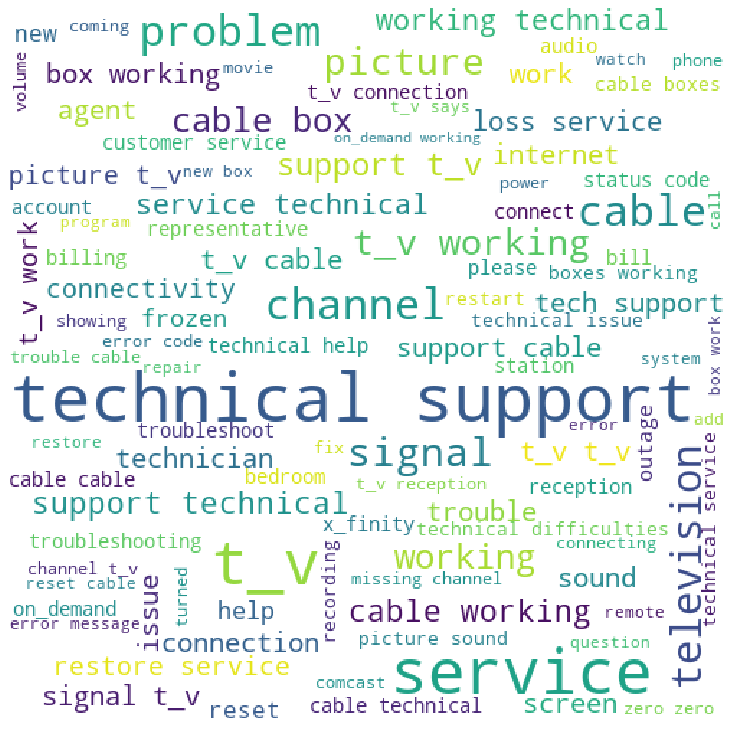

In [158]:
comment_words = ' '
stopwords = set(STOPWORDS) 
#Specify a list of stop words to remove
more_stops=['I','say','wanna','hello','na','gon','get','uh','right','guy','still','come','say','someth','mean','um','oh','yes','bye','great','yeah','no','sorry','ok','okay','thank','like','alright','know','a',
 'about','above','after','again','against','all','also','am','an','and','any','are',"aren't",'as', 'at','be','because','been','before','being','below','between','both','but','by','can',"can't",
            'cannot','com','could',"couldn't",'did', 'ye','my','pai','finity',
            "didn't",'do','does', "doesn't",'doing',"don't",'down','during','each','else','ever', 'few','for','from','further','get','had',"hadn't",'has',"hasn't",'have',"haven't",
'having','he',"he'd","he'll","he's",'her','here',"here's",'hers','herself','him','himself','his','how',"how's",'however','http','i',"i'd","i'll","i'm","i've",'if','in','into','is',"isn't",
 'it',"it's",'its','itself','just','k',"let's",'like','me','more','most',"mustn't",'my','myself','no','nor','not','of','off','on','once','only','or','other','otherwise','ought','our','ours','ourselves',
            'out','over','own','r','same',
            'shall',"shan't",'she',"she'd","she'll","she's",
 'should',"shouldn't",'since','so','some','such','than','that',"that's",'the','their','theirs','them','themselves','then','there',"there's",'these','they',"they'd","they'll","they're","they've",'this','those',
            'through','to',
 'too','under','until','up','very','was','said',"wasn't",'we','got', "we'd","we'll","we're","we've",'were',"weren't",'what',"what's",'when',"when's",'where',"where's",'which','while','who',"who's",'whom',
'why',"why's",'with',"won't",'would',"wouldn't",'www','you',"you'd","you'll","you're","you've",'your','yours','yourself','yourselves','going','see','nothing','well','one','want', 'us', 'for', 'am', 'say', 'and', 'been',
              'someone', 'that', 'so', 'for', 'why', 'am', 'or', 'else', 'main', 'if', 'need', 'do',
              'know', 'want', 'them', 'back', 'will', 'all', 'keep', 'a', 's', 'too', 'at', 'way', 'with',
              'when', 'we', 'with', 'since', 'at', 'does', 're', 'when', 'give', 'talk', 'got',
              'them', 'someone', 'told', 'back', 'way', 'is', 'too', 'its', 'much', 'going', 'keeps',
              'goes', 'every', 'went', 'and', 'been', 'with', 'some', 've', 'we', 'a', 'had', 'and'
    , 'went', 'on', 'all', 'see', 'make', 'say', 'us', 's', 'came','lot','able','takes','think','it','i','try','bit','for',
             'thats','much','getting','really','now','t','turn','for','me',' t','it','getting','now',' me',' t','  t','much',
             'days','now','thought','thats','fact','looking','choose','thing','enough','overall','fine','far',
             'everytime','whenever','always','long','alot','needed','recently','wish','done','usually',
              'sometimes','pretty','month','year','im','change','hold','trying','l','1','ou','d','putting','put',
              'didnt','comes','come','needs','need','seems','seem','tried','try','mostly','sure','certain',
              'cant','can','wanted','want','changes','change','last','first','several','couple','took','take','times',
              'prices','paying','though','thought','feel','live','another','depends','choices',
              'day','minute','minutes','everything','options','better','compared','calling','quickly','week',
              'speak','hours','person','day','faster','less','ten','show','night','theres','part','yet','number',
              'ive','weeks','asked','ask','stuff','little','almost','beleive','believe','dont','somebody',
              'using', 'never','happens','three','five','two','ago','constantly','basically','around','used',
              'others','probably','quite','except','everyone','lost','extremely','higher','wait','tell','kind',
              'end','something','others','job','months','wrong','check','lately','even','provide',
              'job','changing','everybody','second','gets','many','find','supposed','without','taken','gone','cuts',
              'called','use','many','guys','things','whole','anymore','big','understand','rip','realized','robert','kyle','curtis','letting',
              'becoming','depend','elsewhere','effect','letting','tells','sixth','st','stating','st','somehow','frankly','body','originally','op','must'
              ,'automatically','steve','fi','include','anyways'] 

stop_words = set(nltk.corpus.stopwords.words('english')+more_stops)


# iterate through the csv file 
for val in data.REPORTED_UTTERANCE_TEXT: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show() 

In [146]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [143]:
# Convert to list
data = data.REPORTED_UTTERANCE_TEXT.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:2])

['my t_v will not come on',
 'i do not have said picture on my t_v theres a picture demand on_demand on '
 'every single channel and this is']


In [144]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['my', 't_v', 'will', 'not', 'come', 'on']]


In [149]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

['do', 'not', 'have', 'said', 'picture', 'on', 'my', 't_v', 'theres', 'picture', 'demand', 'on_demand', 'on', 'every', 'single', 'channel', 'and', 'this', 'is']


In [150]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

In [152]:
type(data_words_bigrams)

list

In [153]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[]]


In [154]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[]]

In [155]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

In [156]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.625*"cable" + 0.273*"problem" + 0.020*"audio" + 0.014*"record" + '
  '0.008*"blue" + 0.007*"slow" + 0.006*"line" + 0.005*"loss" + 0.004*"cutting" '
  '+ 0.003*"acting"'),
 (1,
  '0.214*"signal" + 0.132*"issue" + 0.126*"internet" + 0.052*"bedroom" + '
  '0.046*"station" + 0.040*"receive" + 0.039*"come" + 0.039*"set" + '
  '0.036*"send" + 0.028*"reset"'),
 (2,
  '0.323*"channel" + 0.297*"working" + 0.165*"trouble" + 0.029*"miss" + '
  '0.026*"frozen" + 0.016*"lock" + 0.011*"available" + 0.010*"remove" + '
  '0.010*"stop" + 0.009*"unable"'),
 (3,
  '0.430*"service" + 0.104*"tech" + 0.078*"help" + 0.064*"agent" + '
  '0.046*"message" + 0.043*"customer" + 0.037*"room" + 0.035*"code" + '
  '0.018*"restore" + 0.014*"status"'),
 (4,
  '0.407*"television" + 0.103*"say" + 0.082*"difficulty" + 0.041*"billing" + '
  '0.034*"fix" + 0.034*"movie" + 0.033*"question" + 0.032*"assistance" + '
  '0.024*"bill" + 0.024*"repair"'),
 (5,
  '0.528*"box" + 0.078*"new" + 0.057*"add" + 0.048*"properly

In [157]:
#model evaluation
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.523758818488958

Coherence Score:  0.5491436461719041


In [ ]:
lda_model.top_topics(bow_corpus)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [464]:
from textblob import TextBlob

In [481]:
data['sentiment'] = data['REPORTED_UTTERANCE_TEXT'].apply(lambda text: TextBlob(text).sentiment.polarity)

In [482]:
data['sentiment'].value_counts()

 0.000000    55058
-0.200000     2348
 0.400000      622
 0.136364      417
-0.500000      273
             ...  
-0.012500        1
-0.138095        1
 0.039057        1
 0.433333        1
 0.080357        1
Name: sentiment, Length: 280, dtype: int64

In [483]:
#positive utternaces
data[["REPORTED_UTTERANCE_TEXT","sentiment"]].loc[(data['sentiment'] > 0)].sample(10)

,REPORTED_UTTERANCE_TEXT,sentiment
212704,had new internet service t_v,0.136364
248961,more services out,0.500000
166264,aren't receiving something not quite right with an error code need technical support,0.142857
634722,yes the picture and the sound not get my t_v,0.400000
906788,new internet no t_v,0.136364
178431,uh i'm having i have a better fire my t_v and i have a picture but it varies small picture,0.125000
506217,my service is not working on the t_v its been off for three hours of more,0.500000
231815,i have no signal on my main t_v in living room,0.166667
771455,i'm handicapped light on but i needed,0.400000
294038,my t_v is not working right there's most of fixing this channel is coming from my,0.392857


In [484]:
#negative utterances
data[["REPORTED_UTTERANCE_TEXT","sentiment"]].loc[(data['sentiment'] < 0)].sample(10)

,REPORTED_UTTERANCE_TEXT,sentiment
915249,black screen t_v,-0.166667
628063,i am unable to change the channels,-0.500000
194293,something wrong with the t_v box because out what i put my t_v says sorry we're having some trouble,-0.400000
529915,cable down,-0.155556
737226,picture reception is awful,-1.000000
442243,no sound on t_v,-0.200000
179663,i'm having trouble what my television,-0.200000
311445,i'm trying to setup my remote quit my t_v,-0.100000
441115,because i have no sound on my t_v,-0.200000
240423,my television is back on output few minutes ago it said i wanted in title to use the x,-0.100000


AutoEncoder to detect Anomaly utterances

In [92]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text,
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        if f not in stop_words:
            s = f(s)
    return s

In [93]:
from collections import Counter

aggregate_counter = Counter()
for row_index,row in data.iterrows():
    c = Counter(row['REPORTED_UTTERANCE_TEXT'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

In [94]:
data['REPORTED_UTTERANCE_TEXT'] = data['REPORTED_UTTERANCE_TEXT'].map(lambda x: clean_text(x))

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

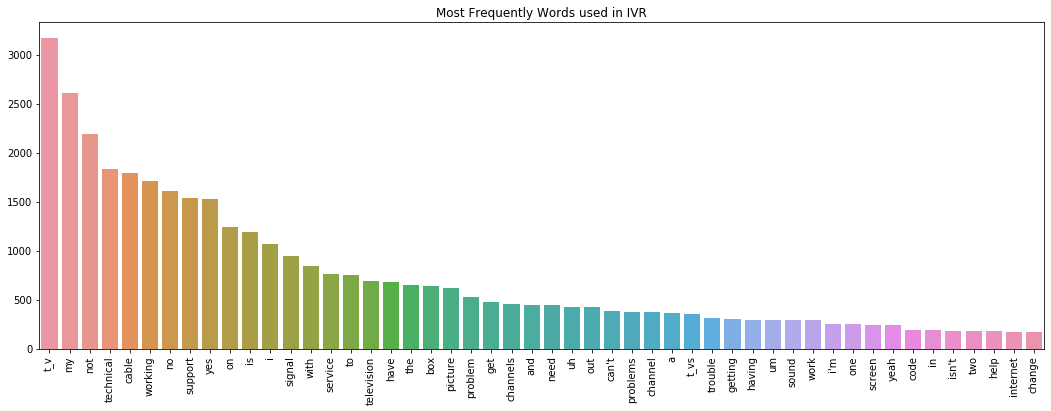

In [96]:
barplot(words=common_words, words_counts=common_words_counts, title='Most Frequently Words used in IVR')

In [97]:
from itertools import islice

def key_word_counter(tupple):
    return tupple[1]

all_word_counts = sorted(aggregate_counter.items(), key=key_word_counter)
uncommon_words = [word[0] for word in islice(all_word_counts, 50)]
uncommon_word_counts = [word[1] for word in islice(all_word_counts, 50)]  

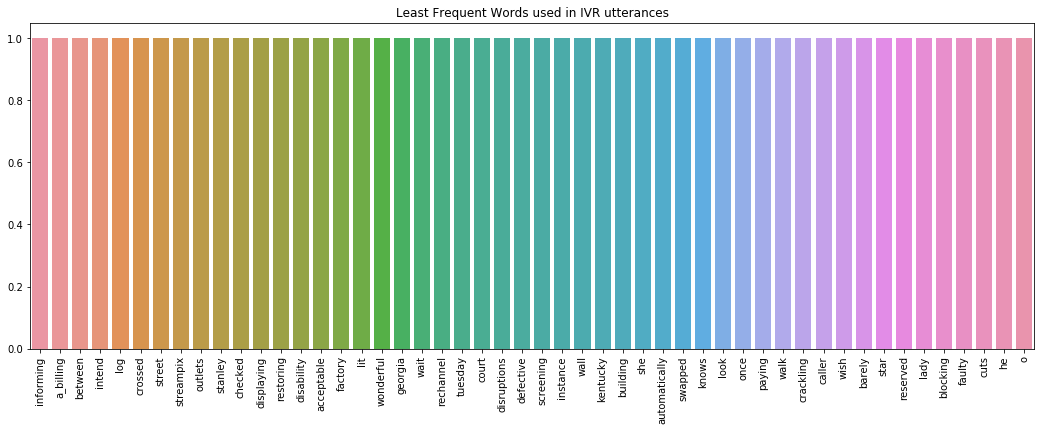

In [98]:
barplot(words=uncommon_words, words_counts=uncommon_word_counts, title='Least Frequent Words used in IVR utterances')

In [14]:
#text documents to word vector
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=15, learning_rate=0.01, epochs=10):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['REPORTED_UTTERANCE_TEXT']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['REPORTED_UTTERANCE_TEXT']).split())
                                     for index, row in df_x.iterrows()]))

In [15]:
doc2vec_tr = Doc2VecTransformer(vector_size=15)
doc2vec_tr.fit(data)
doc2vec_vectors = doc2vec_tr.transform(data)

100%|██████████| 61787/61787 [00:00<00:00, 2562298.78it/s]


In [16]:
print(doc2vec_vectors)

[[        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [ 0.02273718 -0.0112477  -0.02823769 ... -0.021757   -0.0036422
   0.01748796]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]


In [17]:
doc2vec_vectors1 = doc2vec_vectors
doc2vec_vectors1 = np.nan_to_num(doc2vec_vectors1, nan=0, posinf=2, neginf=1)
print(doc2vec_vectors1)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.02273718 -0.0112477  -0.02823769 ... -0.021757   -0.0036422
   0.01748796]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [18]:
#Training an autoencoder
from sklearn.neural_network import MLPRegressor
auto_encoder = MLPRegressor(hidden_layer_sizes=(17,14,17))
auto_encoder.fit(doc2vec_vectors1, doc2vec_vectors1)
predicted_vectors = auto_encoder.predict(doc2vec_vectors1)

In [19]:
auto_encoder.score(predicted_vectors, doc2vec_vectors1)

0.6359283865203083

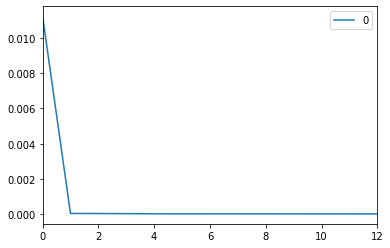

In [20]:
pd.DataFrame(auto_encoder.loss_curve_).plot()

In [21]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(data)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5000):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        if len(data.iloc[index, 0].split())>5:
            print(' ', data.iloc[index, 0])
        #print('Cosine Similarity Value :', consine_sim_val)
        #print('---------------------------------')

In [22]:
# extract n grams from anomaly utterances
def extract_ngrams(data, num):
    n_grams = TextBlob(data).ngrams(num)
    return [ ' '.join(grams) for grams in n_grams]

In [3]:
def display_top_n_grams(sorted_cosine_similarities, n=5000):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        if len(data.iloc[index, 0].split())>6:
            print(extract_ngrams(data.iloc[index, 0], 5)[0:2])
        #print('Cosine Similarity Value :', consine_sim_val)
        #print('---------------------------------')

In [4]:
print('Top 500 UTTERANCES')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors1, predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

Top 500 UTTERANCES


NameError: name 'doc2vec_vectors1' is not defined

In [480]:
print('Top 500 POTENTIAL EMERGING TOPICS')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors1, predicted_vectors=predicted_vectors)
display_top_n_grams(sorted_cosine_similarities=sorted_cosine_similarities)

Top 500 POTENTIAL EMERGING TOPICS
['well i have no picture', 'i have no picture screen']
['speak to rep problems with', 'to rep problems with my']
['t_v in living room says', 'in living room says no']
['message across screen device tech', 'across screen device tech restart']
['your number cable cost my', 'number cable cost my screen']
['my television a purchase channel', 'television a purchase channel does']
['need help um support with', 'help um support with our']
['t_v is not working returned', 'is not working returned change']
["i do n't have any", "do n't have any picture"]
['one of my t_v is', 'of my t_v is not']
['message r_d_k zero three zero', 'r_d_k zero three zero five']
['error code x_r_e zero three', 'code x_r_e zero three zero']
['my t_v is out and', 't_v is out and i']
['no picture on or sound', 'picture on or sound on']
['no picture add box not', 'picture add box not working']
["i ca n't get the", "ca n't get the television"]
["my t_v wo n't turn", "t_v wo n't turn on"]


In [294]:
sorted_cosine_similarities1 = pd.DataFrame(sorted_cosine_similarities)

In [ ]:
sorted_cosine_similarities1.head(10)

In [308]:
extract_ngrams("a blue light solid blue come over screen from time time we don't", 5)[1]

'blue light solid blue come'

In [305]:
extract_ngrams("live picture keeps doesn't sound is dropping out the picture keeps stalling", 5)[1]

"picture keeps does n't sound"

In [317]:
extract_ngrams("someone menu has changed i don't get channels that i'm supposed to get", 5)[1]

'menu has changed i do'